### Hawai'i 2022 General PBER Annotated file
I annotated this more than usual to illustrate my steps. A clean version of my code is also available and titled "AMR_HIG22_Clean"


### Sources
- [Hawaii Election results file from MEDSL](https://github.com/MEDSL/2022-elections-official/blob/main/individual_states/2022-hi-local-precinct-general.zip)
- [Hawaii Precinct boundaries](https://geoportal.hawaii.gov/datasets/HiStateGIS::election-precincts/about)
- [State Office of Elections Certified Report Summaries](https://elections.hawaii.gov/election-results/)
- [State Office of Elections Certified Precinct Detail Report](https://elections.hawaii.gov/wp-content/results/precinct.pdf)

In [1]:
# load packages
import numpy as np
import pandas as pd
import geopandas as gpd
pd.set_option('display.max_rows', None) #see all columns of dataframe

In [2]:
# Load in files
gdf = gpd.read_file('HISHP/Election_Precincts.shp')
er = pd.read_csv('HI-cleaned.csv')

In [3]:
# check both dataframes for number of unique precincts and unique precinct ID for later merging
#er.precinct.nunique() # 236 
#gdf.dp.nunique() # 248

In [4]:
# CHECK
#er.precinct.head(1) == gdf.dp.head(1)
#gdf.dp.head()
#gdf.dp.dtype

#### summary
- 12 More precincts in shapefile than in election returns data frame, will need to look into 12 'nonvoting' areas in shapefile
- unique precinct id present in same format in both dfs for later merging

### Preparing Shapefile for merging
Referenced [Metadata for shapefile](https://files.hawaii.gov/dbedt/op/gis/data/precincts.pdf)

#### summary

- Converted districts 18-05 and 42-01 from multiple geographies to multipolygons
- subset df to columns required in final merged df

In [5]:
# CHECK
#gdf.crs

In [6]:
gdf.columns

Index(['objectid', 'dp', 'dpnum', 'dptype', 'county', 'zeropop', 'ballottype',
       'us_house', 'state_hous', 'state_sena', 'county_cou', 'st_areasha',
       'st_perimet', 'geometry'],
      dtype='object')

In [7]:
# check # of zero pop precincts
gdf[['dptype']].value_counts() #239, still 3 more than er df

dptype 
VBMO       239
ZEROPOP     11
dtype: int64

In [8]:
gdf.shape # gdf has 250 rows, but 248 unique precincts

(250, 14)

In [9]:
# gdf['ballottype'].unique().size #some precincts have same ballot type, precincts smaller than county council districts

In [10]:
# look for duplicates
#gdf['objectid'].nunique() #250
gdf['dp'].nunique() #248

248

In [11]:
# filtering duplicated rows
gdf[gdf.duplicated(subset='dp', keep=False)]

,objectid,dp,dpnum,dptype,county,zeropop,ballottype,us_house,state_hous,state_sena,county_cou,st_areasha,st_perimet,geometry
246,247,42-01,4201,VBMO,OAHU,None,CD1-H42-S20-CC9,CD1,H42,S20,CC9,9.219847e+04,1370.015977,"POLYGON ((-158.03044 21.33709, -158.03090 21.3..."
247,248,42-01,4201,VBMO,OAHU,None,CD1-H42-S20-CC9,CD1,H42,S20,CC9,2.152954e+05,2002.045649,"POLYGON ((-158.02814 21.34041, -158.02829 21.3..."
248,249,18-05,1805,VBMO,OAHU,None,CD1-H18-S09-CC4,CD1,H18,S09,CC4,2.572862e+05,2852.785704,"POLYGON ((-157.71873 21.28422, -157.71864 21.2..."
249,250,18-05,1805,VBMO,OAHU,None,CD1-H18-S09-CC4,CD1,H18,S09,CC4,2.780304e+06,11075.929342,"POLYGON ((-157.70717 21.31775, -157.70638 21.3..."


noticing that for each pair, every column seems to be duplicated exactly, except columns pertaining to geometry.

<AxesSubplot:>

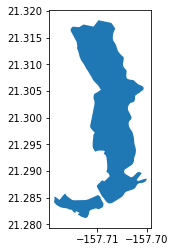

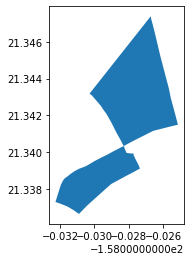

In [12]:
# look at geometries of precinct 18-05, and 42-01
gdf.iloc[[-1,-2]].plot()
gdf.iloc[[-3,-4]].plot()

For each pair, the two geometries seem to comprise one non-contiguous precinct. Looked at all four of these geometries in QGIS with OSM to confirm they are two precincts.

In [13]:
#check before changing df
len(gdf.dissolve(by= 'dp'))

248

In [14]:
gdf = gdf.dissolve(by= 'dp').reset_index()

In [15]:
gdf.head()

,dp,geometry,objectid,dpnum,dptype,county,zeropop,ballottype,us_house,state_hous,state_sena,county_cou,st_areasha,st_perimet
0,01-01,"POLYGON ((-155.69865 20.18589, -155.69855 20.1...",1,101,VBMO,HAWAII,None,CD2-H01-S04-CC1,CD2,H01,S04,CC1,9.949400e+08,243835.454121
1,01-02,"POLYGON ((-155.08329 19.85094, -155.08346 19.8...",2,102,VBMO,HAWAII,None,CD2-H01-S01-CC1,CD2,H01,S01,CC1,1.996375e+08,90596.525487
2,01-03,"POLYGON ((-155.33399 19.78996, -155.33385 19.7...",3,103,VBMO,HAWAII,None,CD2-H01-S01-CC2,CD2,H01,S01,CC2,4.157142e+08,96097.575789
3,01-04,"POLYGON ((-155.43905 19.90430, -155.43883 19.9...",4,104,ZEROPOP,HAWAII,yes,CD2-H01-S04-CC2,CD2,H01,S04,CC2,4.202857e+08,100538.651270
4,02-01,"POLYGON ((-155.08683 19.72785, -155.08679 19.7...",5,201,VBMO,HAWAII,None,CD2-H02-S01-CC2,CD2,H02,S01,CC2,1.954235e+07,28533.769583


In [16]:
#check # of populated unique precincts in shapefile
gdf['dp'].nunique() - int(gdf['zeropop'].value_counts())

237

Shapefile still has 1 more 'populated' precinct than the election returns

In [17]:
#more investigating
gdf.columns

Index(['dp', 'geometry', 'objectid', 'dpnum', 'dptype', 'county', 'zeropop',
       'ballottype', 'us_house', 'state_hous', 'state_sena', 'county_cou',
       'st_areasha', 'st_perimet'],
      dtype='object')

In [18]:
gdf.county.value_counts() #good to know for later, # of precincts in each county in this shapefile, and # and name of counties

OAHU      154
HAWAII     42
MAUI       36
KAUAI      16
Name: county, dtype: int64

In [19]:
#desperation searching for anomalous final precinct
#gdf.county_cou.nunique()
#gdf.ballottype.value_counts()

Looked at previous [PBER files on RDH github](https://github.com/nonpartisan-redistricting-datahub/pber_collection) to see column conventions

1. PRECINCT   County precinct identifier
2. SLDL_DIST  State House District
3. SLDU_DIST  State Senate District  

In [20]:
#subset gdf for merging
gdf_sub = gdf[['dp', 'county', 'us_house', 'state_hous', 'state_sena','geometry']].copy()

In [21]:
#rename columns
cols = ['PRECINCT', 'COUNTY', 'USHOUSE', 'SLDL', 'SLDU', 'geometry']
gdf_sub.columns = cols
gdf_sub.head(2)

,PRECINCT,COUNTY,USHOUSE,SLDL,SLDU,geometry
0,01-01,HAWAII,CD2,H01,S04,"POLYGON ((-155.69865 20.18589, -155.69855 20.1..."
1,01-02,HAWAII,CD2,H01,S01,"POLYGON ((-155.08329 19.85094, -155.08346 19.8..."


In [22]:
gdf_sub['SLDL'] = gdf_sub['SLDL'].apply(lambda x: str(x)[1:])
gdf_sub['SLDU'] = gdf_sub['SLDU'].apply(lambda x: str(x)[1:])
gdf_sub['USHOUSE'] = gdf_sub['USHOUSE'].apply(lambda x: str(x)[2:])

In [23]:
# CHECK
gdf_sub.head(2)

,PRECINCT,COUNTY,USHOUSE,SLDL,SLDU,geometry
0,01-01,HAWAII,2,01,04,"POLYGON ((-155.69865 20.18589, -155.69855 20.1..."
1,01-02,HAWAII,2,01,01,"POLYGON ((-155.08329 19.85094, -155.08346 19.8..."


### Preparing Elections Returns for merging

#### summary

- subset to statewide offices, or offices pertaining to a state-wide governing body
- Modified to VEST naming conventions (with further modifications to ensure under 10 letter naming convention for offices with contests in districts)
- subset df to columns required in final merged df
- created df for readme key

In [24]:
#er.head()
#er.shape()
#er.isnull().sum()

In [25]:
# Checck Write In
er.writein.value_counts()

False    16555
Name: writein, dtype: int64

In [26]:
#check how many unique precincts
er['precinct'].nunique()

236

In [27]:
er.office.unique()

array(['US SENATE', 'US HOUSE', 'GOVERNOR', 'STATE SENATOR',
       'HAWAII RESIDENT TRUSTEE VACANCY', 'AT-LARGE TRUSTEE',
       "1 HAWAI'I: MEMBERSHIP FOR THE BOARD OF ETHICS",
       "2 HAWAI'I: EXPANDING THE DUTIES OF THE COUNTY AUDITOR",
       "3 HAWAI'I: ESTABLISHING A YOUTH COMMISSION", 'COUNCILMEMBER',
       'STATE HOUSE', 'MAYOR', 'COUNCILMEMBER (EAST MAUI)',
       'COUNCILMEMBER (WEST MAUI)',
       'COUNCILMEMBER (WAILUKU-WAIHEE-WAIKAPU)',
       'COUNCILMEMBER (KAHULUI)', 'COUNCILMEMBER (SOUTH MAUI)',
       'COUNCILMEMBER (MAKAWAO-HAIKU-PAIA)', 'COUNCILMEMBER (UPCOUNTRY)',
       'COUNCILMEMBER (LANAI)', 'COUNCILMEMBER (MOLOKAI)',
       'MAUI COMMISSION PROPOSAL 1: CREATE A SEPARATE HOUSING DEPARTMENT DEDICATED TO AFFORDABLE HOUSING; INCLUDING AN ADVISORY BOARD AND HAWAIIAN HOME LANDS LIAISON',
       "MAUI COMMISSION PROPOSAL 2: DEPARTMENT OF 'OIWI RESOURCES",
       'MAUI COMMISSION PROPOSAL 3: ETHICS AND FINANCIAL DISCLOSURES',
       'MAUI COMMISSION PROPOSAL 4: PL

Checked [Ballotpedia](https://ballotpedia.org/Hawaii_state_executive_official_elections,_2022) for statewide races, and races pertaining to a state-wide governing body. There are 7 types of offices that fit this criteria.

    - US Senate
    - US House
    - Governor/Lt Gov
    - State Senator
    - State House
    - Office of Hawaiian Affairs At Large Trustee
    - Office of Hawaiian Affairs Resident Trustee

    - charter questions are COUNTY wide
    - councilmembers are also COUNTY wide

In [28]:
# subset df to rows pertaining to offices of interest
office_list = ['US SENATE', 'US HOUSE', 'GOVERNOR', 'STATE SENATOR', 'STATE HOUSE', 'AT-LARGE TRUSTEE', 'HAWAII RESIDENT TRUSTEE VACANCY']
er_sub = er[er['office'].isin(office_list)]

In [29]:
# CHECK, looking for 7 types of races
er_sub.office.value_counts().nunique()

7

In [30]:
er_sub.head(2)

,precinct,district,office,writein,party_detailed,party_simplified,candidate,dataverse,mode,votes,...,state_fips,state_cen,state_ic,date,jurisdiction_fips,county_name,county_fips,readme_check,magnitude,special
0,01-01,NaN,US SENATE,False,LIBERTARIAN,LIBERTARIAN,FEENA M BONOAN,SENATE,MAIL IN,35,...,15,95,82,2022-11-08,15001,HAWAII,15001,True,1,False
1,01-01,NaN,US SENATE,False,ALOHA AINA PARTY,OTHER,DAN DECKER,SENATE,MAIL IN,19,...,15,95,82,2022-11-08,15001,HAWAII,15001,True,1,False


In [31]:
#subset columns
er_sub = er_sub[['precinct', 'office', 'district', 'party_detailed', 'candidate', 'mode', 'votes']]

In [32]:
er_sub.head()

,precinct,office,district,party_detailed,candidate,mode,votes
0,01-01,US SENATE,NaN,LIBERTARIAN,FEENA M BONOAN,MAIL IN,35
1,01-01,US SENATE,NaN,ALOHA AINA PARTY,DAN DECKER,MAIL IN,19
2,01-01,US SENATE,NaN,REPUBLICAN,BOB MCDERMOTT,MAIL IN,609
3,01-01,US SENATE,NaN,GREEN,EMMA JANE A POHLMAN,MAIL IN,29
4,01-01,US SENATE,NaN,DEMOCRAT,BRIAN SCHATZ,MAIL IN,2521


Adapting VEST field naming convention, these are the office codes
##### (modified for contests with districts, to fit GIS 10 character limit)

- USS - U.S. Senate
- CD# - U.S. Congress District
- GOV - Governor/Lieutenant Governor
- SL##  - State Legislative Lower District ##
- SU##  - State Legislative Upper District ##
- ALT - Office of Hawaiian Affairs, At Large Trustee
- RTH - Office of Hawaiian Affairs, Resident Trustee for Hawaii (H - Hawaii, M - Maui, O - Oahu) **general election only occured for county of Hawaii

In [33]:
office_list = list(er_sub['office'].unique())
office_list

['US SENATE',
 'US HOUSE',
 'GOVERNOR',
 'STATE SENATOR',
 'HAWAII RESIDENT TRUSTEE VACANCY',
 'AT-LARGE TRUSTEE',
 'STATE HOUSE']

In [34]:
#rename offices
new_office_list = ['G22USS', 'G22CD', 'G22GOV', 'GSU', 'G22RTH', 'G22ALT', 'GSL']
er_sub['race'] = er_sub['office']
er_sub['race'].replace(office_list, new_office_list, inplace=True)

In [35]:
er_sub.head(2)

,precinct,office,district,party_detailed,candidate,mode,votes,race
0,01-01,US SENATE,NaN,LIBERTARIAN,FEENA M BONOAN,MAIL IN,35,G22USS
1,01-01,US SENATE,NaN,ALOHA AINA PARTY,DAN DECKER,MAIL IN,19,G22USS


Will need State Senate, State House, and US congressional districts to complete naming convention. Will append from gdf.

In [36]:
#merge subset of gdf to append columns for districts
er_sub = pd.merge(er_sub,gdf_sub[['PRECINCT', 'USHOUSE', 'SLDL', 'SLDU']],left_on='precinct', right_on = 'PRECINCT', how= 'left', indicator = True)

In [37]:
#check indicator to see if merge was successful
er_sub._merge.value_counts()

both          9372
left_only        0
right_only       0
Name: _merge, dtype: int64

In [38]:
er_sub.head(2)

,precinct,office,district,party_detailed,candidate,mode,votes,race,PRECINCT,USHOUSE,SLDL,SLDU,_merge
0,01-01,US SENATE,NaN,LIBERTARIAN,FEENA M BONOAN,MAIL IN,35,G22USS,01-01,2,01,04,both
1,01-01,US SENATE,NaN,ALOHA AINA PARTY,DAN DECKER,MAIL IN,19,G22USS,01-01,2,01,04,both


In [39]:
#replace 'CD#' with Congressional District
er_sub.loc[er_sub.race=='G22CD', 'race'] =  er_sub['race'] + er_sub['USHOUSE']
#replace 'SU#' with SLDU
er_sub.loc[er_sub.race=='GSU', 'race'] = er_sub['race'] + er_sub['SLDU']
#replace 'SL#' with SLDL
er_sub.loc[er_sub.race=='GSL', 'race'] = er_sub.race + er_sub['SLDL']

In [40]:
#check
er_sub.race.value_counts().nunique()

32

Before modifying party column, checking for how non-partisan or unregistered is noted

In [41]:
er_sub['party_detailed'].value_counts()

REPUBLICAN          2145
DEMOCRAT            2141
LIBERTARIAN          614
GREEN                401
ALOHA AINA PARTY     378
Name: party_detailed, dtype: int64

In [42]:
er_sub['party_detailed'].isnull().sum()

3693

In [43]:
#change null to NONPARTISAN/UNREGISTERED
er_sub['party_detailed'].fillna('NONPARTISAN/UNREGISTERED', inplace = True)

In [44]:
#append 1 letter party to make VEST column
er_sub['VEST'] = er_sub['race'] + er_sub['party_detailed'].apply(lambda x : str(x)[0])
#create 3 letter party for readme
er_sub['party_detailed'] = er_sub['party_detailed'].apply(lambda x: str(x)[:3].upper())

Before modifying candidate names for README, double check for write-in candidates

In [45]:
('WRITE IN' in er_sub['candidate'].unique())

False

In [46]:
#double check visually

#er_sub['candidate'].value_counts()

In [47]:
#append 3 letter last name to 'VEST' column
er_sub['VEST'] = er_sub['VEST'] + er_sub['candidate'].apply(lambda x: str(x).split()[-1][:3])

In [48]:
#create candidate column for readme
er_sub['candidate'] = er_sub['candidate'].apply(lambda x: str(x).split()[-1] + ', ' + ' '.join(str(x).split()[:-1]))

In [49]:
#add 3 letter party
er_sub['candidate'] += ' - ' + er_sub['party_detailed']

In [50]:
er_sub.head()

,precinct,office,district,party_detailed,candidate,mode,votes,race,PRECINCT,USHOUSE,SLDL,SLDU,_merge,VEST
0,01-01,US SENATE,NaN,LIB,"BONOAN, FEENA M - LIB",MAIL IN,35,G22USS,01-01,2,01,04,both,G22USSLBON
1,01-01,US SENATE,NaN,ALO,"DECKER, DAN - ALO",MAIL IN,19,G22USS,01-01,2,01,04,both,G22USSADEC
2,01-01,US SENATE,NaN,REP,"MCDERMOTT, BOB - REP",MAIL IN,609,G22USS,01-01,2,01,04,both,G22USSRMCD
3,01-01,US SENATE,NaN,GRE,"POHLMAN, EMMA JANE A - GRE",MAIL IN,29,G22USS,01-01,2,01,04,both,G22USSGPOH
4,01-01,US SENATE,NaN,DEM,"SCHATZ, BRIAN - DEM",MAIL IN,2521,G22USS,01-01,2,01,04,both,G22USSDSCH


In [51]:
#check party value_counts
er_sub['party_detailed'].value_counts()

NON    3693
REP    2145
DEM    2141
LIB     614
GRE     401
ALO     378
Name: party_detailed, dtype: int64

In [52]:
#drop extra columns
er_sub.drop(labels = ['PRECINCT', 'district','party_detailed','USHOUSE', 'SLDL', 'SLDU', '_merge'], axis = 1, inplace = True)

In [53]:
er_sub.head(2)

,precinct,office,candidate,mode,votes,race,VEST
0,01-01,US SENATE,"BONOAN, FEENA M - LIB",MAIL IN,35,G22USS,G22USSLBON
1,01-01,US SENATE,"DECKER, DAN - ALO",MAIL IN,19,G22USS,G22USSADEC


In [54]:
#subset df for readme creation
rm = er_sub[['office', 'race', 'VEST', 'candidate']].copy().drop_duplicates(keep = 'first')

In [55]:
rm.shape #157 candidates

(157, 4)

In [56]:
rm.head(2)

,office,race,VEST,candidate
0,US SENATE,G22USS,G22USSLBON,"BONOAN, FEENA M - LIB"
1,US SENATE,G22USS,G22USSADEC,"DECKER, DAN - ALO"


### Pivoting Elections Return Data + Checking Vote Totals

#### summary

- 2 vote total discrepancies for 2 candidates for US Senate, Bonoan and Decker


In [57]:
er_pivot = er_sub.pivot_table(index = ['precinct'],
                         columns = ['office', 'race', 'candidate'],
                        values = ['votes'],
                         aggfunc = 'sum',
                              fill_value=0,
                             margins = True)#.reset_index()

In [58]:
er_pivot.shape #looking for 236

(237, 158)

In [59]:
er_pivot.tail()

votes                                 \
office              AT-LARGE TRUSTEE                                  
race                          G22ALT                                  
candidate GALUTERIA, BRICKWOOD - NON ISA, LEI 'LEINA'ALA' AHU - NON   
precinct                                                              
51-02                            950                            696   
51-03                            779                            619   
51-04                            550                            426   
51-05                            796                            541   
All                           139611                         120088   

                                                                              \
office                                                                         
race                                                                           
candidate KING, SAM 'KALANIKUPUA' - NON OWENS, CHAD - NON SOUZA, KEONI - NON   
precinct                                                                       
51-02                               826               796                972   
51-03                               598               607                765   
51-04                               284               520                677   
51-05                               403               663                968   
All                              103299            118561             135124   

                                                                               \
office                                        GOVERNOR                          
race                                            G22GOV                          
candidate WAIHEE, JOHN D - NON AIONA, DUKE TUPAI - REP GREEN, JOSH LUKE - DEM   
precinct                                                                        
51-02                      702                     953                   1773   
51-03                      654                     786                   1431   
51-04                      434                     586                    694   
51-05                      542                     752                    933   
All                     131033                  152237                 261025   

                                                                   ...  \
office    HAWAII RESIDENT TRUSTEE VACANCY                          ...   
race                               G22RTH                          ...   
candidate   CERMELJ, HOPE ALOHALANI - NON TRASK, MILILANI B - NON  ...   
precinct                                                           ...   
51-02                                 727                    1103  ...   
51-03                                 584                     880  ...   
51-04                                 334                     724  ...   
51-05                                 374                    1088  ...   
All                                107669                  176648  ...   

                                                                             \
office               US HOUSE                                                 
race                   G22CD1           G22CD2                                
candidate KRESS, CONRAD - REP AKANA, JOE - REP TIPPENS, MICHELLE ROSE - LIB   
precinct                                                                      
51-02                       0              847                           41   
51-03                       0              681                           42   
51-04                       0              489                           30   
51-05                       0              626                           33   
All                     51217            72874                         5130   

                                                                        \
office                                     US SENATE                     
race                        

In [60]:
er_pivot.columns = er_pivot.columns.droplevel(level =0)

In [61]:
er_pivot.columns[1]

('AT-LARGE TRUSTEE', 'G22ALT', "ISA, LEI 'LEINA'ALA' AHU - NON")

Manually check race vote totals against [State PDF Summary](https://elections.hawaii.gov/wp-content/results/histatewide.pdf)

In [62]:
for item in (office_list):
    print('****' + item + '*****')
    print(er_pivot[[(item)]].sum().astype(int).sort_index(level = 2))

****US SENATE*****
office     race    candidate                 
US SENATE  G22USS  BONOAN, FEENA M - LIB           9830
                   DECKER, DAN - ALO               4416
                   MCDERMOTT, BOB - REP          212716
                   POHLMAN, EMMA JANE A - GRE      8284
                   SCHATZ, BRIAN - DEM           581788
dtype: int32
****US HOUSE*****
office    race    candidate                   
US HOUSE  G22CD2  AKANA, JOE - REP                145748
          G22CD1  CASE, ED - DEM                  287092
                  KRESS, CONRAD - REP             102434
          G22CD2  TIPPENS, MICHELLE ROSE - LIB     10260
                  TOKUDA, JILL N - DEM            256814
dtype: int32
****GOVERNOR*****
office    race    candidate              
GOVERNOR  G22GOV  AIONA, DUKE TUPAI - REP    304474
                  GREEN, JOSH LUKE - DEM     522050
dtype: int32
****STATE SENATOR*****
office         race   candidate                      
STATE SENATOR  GSU23  AWA

#TODO/Anomalies
- US Senate
    - Bonoan 4876 instead of 4915
    - Decker 2189 instead of 2208

In [63]:
#Investigate anomalies in Senate undercounts for Bonoan and Decker
bonoan = 4915-4876
print('Bonoan is missing ' + str(bonoan) + ' votes')
decker = 2208-2189
print('Decker is missing ' + str(decker)+ ' votes')

Bonoan is missing 39 votes
Decker is missing 19 votes


Checking against [Hawai'i county and precinct PDFs](https://elections.hawaii.gov/wp-content/results/precinct.pdf)


In precinct 01-01
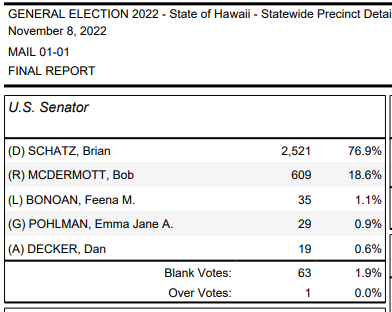

### Merge Precincts Shapefile

In [64]:
er_p2 = er_sub.pivot_table(index = ['precinct'],
                         columns = ['VEST'],
                        values = ['votes'],
                         aggfunc = 'sum',
                              fill_value=0,
                           margins = True,
                           margins_name = 'tv'
                          ).reset_index()

In [65]:
er_p2.head()

precinct      votes                                              \
VEST          G22ALTNGAL G22ALTNISA G22ALTNKIN G22ALTNOWE G22ALTNSOU   
0       01-01       1098        746        764        765       1309   
1       01-02        689        559        502        544        772   
2       01-03       1149        813        662        805       1189   
3       01-04          0          0          0          0          0   
4       02-01       1916       1268       1024       1274       1595   

                                                  ...                      \
VEST G22ALTNWAI G22CD1DCAS G22CD1RKRE G22CD2DTOK  ... GSU21RKHA GSU22DSHI   
0          1164          0          0       2225  ...         0         0   
1           810          0          0       1479  ...         0         0   
2          1086          0          0       2265  ...         0         0   
3             0          0          0          1  ...         0         0   
4          1845          0          0       3797  ...         0         0   

                                                                            \
VEST GSU22RDEC GSU23DRIV GSU23RAWA GSU24DKEO GSU24RFER GSU25DLEE GSU25RLAU   
0            0         0         0         0         0         0         0   
1            0         0         0         0         0         0         0   
2            0         0         0         0         0         0         0   
3            0         0         0         0         0         0         0   
4            0         0         0         0         0         0         0   

             
VEST     tv  
0     21112  
1     14156  
2     21077  
3         4  
4     32808  

[5 rows x 159 columns]

In [66]:
#format columns
er_p2.columns = er_p2.columns.droplevel(level =0)
er_p2.columns = ['PRECINCT'] + list(er_p2.columns[1:])

In [67]:
#drop indicator column
er_p2.drop('tv',axis=1, inplace = True)

In [68]:
#subset totals for README creation
rm_tv = er_p2.iloc[-1].to_frame().reset_index()

In [69]:
#drop total row
er_p2.drop((len(er_p2)-1), axis = 0, inplace = True)

In [70]:
#er_p2

In [71]:
#join shapefile
jer = pd.merge(er_p2,gdf_sub[['PRECINCT','geometry']], on = 'PRECINCT', how= 'right', indicator = True)
jer._merge.value_counts()

both          236
right_only     12
left_only       0
Name: _merge, dtype: int64

Noticing that all precincts successfully merged, including the 12 precincts that had no votes/election returns.

In [72]:
#drop indicator column
jer.drop('_merge',axis=1, inplace = True)

### Final Checks + Export Joined Data Set

In [73]:
#TODO Check to see if length of cols is 10 characters or less
#[i for i in jer.columns if len(i)>10]

In [74]:
jer.to_csv('HIG22PBER')

### Creating README

In [75]:
rm_tv = rm_tv.iloc[1:]

In [76]:
rm_tv.columns = ['VEST', 'TOT_VOTES']

In [77]:
rm_tv

,VEST,TOT_VOTES
1,G22ALTNGAL,139611
2,G22ALTNISA,120088
3,G22ALTNKIN,103299
4,G22ALTNOWE,118561
5,G22ALTNSOU,135124
6,G22ALTNWAI,131033
7,G22CD1DCAS,143546
8,G22CD1RKRE,51217
9,G22CD2DTOK,128407
10,G22CD2LTIP,5130


In [78]:
rm

,office,race,VEST,candidate
0,US SENATE,G22USS,G22USSLBON,"BONOAN, FEENA M - LIB"
1,US SENATE,G22USS,G22USSADEC,"DECKER, DAN - ALO"
2,US SENATE,G22USS,G22USSRMCD,"MCDERMOTT, BOB - REP"
3,US SENATE,G22USS,G22USSGPOH,"POHLMAN, EMMA JANE A - GRE"
4,US SENATE,G22USS,G22USSDSCH,"SCHATZ, BRIAN - DEM"
5,US HOUSE,G22CD2,G22CD2RAKA,"AKANA, JOE - REP"
6,US HOUSE,G22CD2,G22CD2LTIP,"TIPPENS, MICHELLE ROSE - LIB"
7,US HOUSE,G22CD2,G22CD2DTOK,"TOKUDA, JILL N - DEM"
8,GOVERNOR,G22GOV,G22GOVRAIO,"AIONA, DUKE TUPAI - REP"
9,GOVERNOR,G22GOV,G22GOVDGRE,"GREEN, JOSH LUKE - DEM"


In [79]:
rm = pd.merge(rm,rm_tv,on = 'VEST', how= 'right', indicator = True)

In [80]:
rm._merge.value_counts()

both          157
left_only       0
right_only      0
Name: _merge, dtype: int64

In [81]:
rm.head()

,office,race,VEST,candidate,TOT_VOTES,_merge
0,AT-LARGE TRUSTEE,G22ALT,G22ALTNGAL,"GALUTERIA, BRICKWOOD - NON",139611,both
1,AT-LARGE TRUSTEE,G22ALT,G22ALTNISA,"ISA, LEI 'LEINA'ALA' AHU - NON",120088,both
2,AT-LARGE TRUSTEE,G22ALT,G22ALTNKIN,"KING, SAM 'KALANIKUPUA' - NON",103299,both
3,AT-LARGE TRUSTEE,G22ALT,G22ALTNOWE,"OWENS, CHAD - NON",118561,both
4,AT-LARGE TRUSTEE,G22ALT,G22ALTNSOU,"SOUZA, KEONI - NON",135124,both


In [86]:
rm[rm['office'] == 'US SENATE']

,office,race,VEST,candidate,TOT_VOTES,_merge
15,US SENATE,G22USS,G22USSADEC,"DECKER, DAN - ALO",2208,both
16,US SENATE,G22USS,G22USSDSCH,"SCHATZ, BRIAN - DEM",290894,both
17,US SENATE,G22USS,G22USSGPOH,"POHLMAN, EMMA JANE A - GRE",4142,both
18,US SENATE,G22USS,G22USSLBON,"BONOAN, FEENA M - LIB",4915,both
19,US SENATE,G22USS,G22USSRMCD,"MCDERMOTT, BOB - REP",106358,both


In [82]:
#v1
races_list = []
for i in office_list:
    subdf = rm[rm['office'] == i]
    

US SENATE
US HOUSE
GOVERNOR
STATE SENATOR
HAWAII RESIDENT TRUSTEE VACANCY
AT-LARGE TRUSTEE
STATE HOUSE


In [83]:
rm

,office,race,VEST,candidate,TOT_VOTES,_merge
0,AT-LARGE TRUSTEE,G22ALT,G22ALTNGAL,"GALUTERIA, BRICKWOOD - NON",139611,both
1,AT-LARGE TRUSTEE,G22ALT,G22ALTNISA,"ISA, LEI 'LEINA'ALA' AHU - NON",120088,both
2,AT-LARGE TRUSTEE,G22ALT,G22ALTNKIN,"KING, SAM 'KALANIKUPUA' - NON",103299,both
3,AT-LARGE TRUSTEE,G22ALT,G22ALTNOWE,"OWENS, CHAD - NON",118561,both
4,AT-LARGE TRUSTEE,G22ALT,G22ALTNSOU,"SOUZA, KEONI - NON",135124,both
5,AT-LARGE TRUSTEE,G22ALT,G22ALTNWAI,"WAIHEE, JOHN D - NON",131033,both
6,US HOUSE,G22CD1,G22CD1DCAS,"CASE, ED - DEM",143546,both
7,US HOUSE,G22CD1,G22CD1RKRE,"KRESS, CONRAD - REP",51217,both
8,US HOUSE,G22CD2,G22CD2DTOK,"TOKUDA, JILL N - DEM",128407,both
9,US HOUSE,G22CD2,G22CD2LTIP,"TIPPENS, MICHELLE ROSE - LIB",5130,both


## TESTING HELPER FUNCTIONS

In [84]:
# for i in office_list:
#     i

In [85]:
# def get_races(office_list, df):
#     for i in office_list:
#         i_lst = []
#         races_list = sorted(list(df[df.office == i]['race'].unique()))
#         for ele in races_list:
        